# 9. CART
决策树的构建算法是ID3**（著名的ID3决策树学习算法[Quinlan, 1986]就是以信息增益为准则来选择划分属性）**。ID3的做法是每次选取当前最佳的特征来分割数据，并按照该特征的所有可能取值来切分。另一种切分方式是二元切分，即每次把数据切成两份，如果数据的某特征值等于切分所要求的值，那么这些数据就进入树的左子树，反之则进入树的右子树。  
CART使用二元切分来处理连续变量。

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# 根据阈值将数据集分为两部分
def binSplitDataSet(dataSet, feature, value):
    mat0 = dataSet[np.nonzero(dataSet[:,feature] > value)[0],:]
    mat1 = dataSet[np.nonzero(dataSet[:,feature] <= value)[0],:]
    return mat0, mat1

createTree伪代码：
```
找到最佳的待切分特征：
    如果该节点不能再分，将该节点存为叶节点
    执行二元切分
    在右子树调用createTree()方法
    在左子树调用createTree()方法
```

In [5]:
def createTree(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):
    feat, val = chooseBestSplit(dataSet, leafType, errType, ops)
    if feat == None:
        return val
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    lSet, rSet = binSplitDataSet(dataSet, feat, val)
    retTree['left'] = createTree(lSet, leafType, errType, ops)
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    return retTree

In [6]:
testMat = np.mat(np.eye(4))
mat0,mat1 = binSplitDataSet(testMat,1,0.5)

In [7]:
mat0

matrix([[0., 1., 0., 0.]])

In [8]:
mat1

matrix([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [9]:
# 回归树的切分函数
def regLeaf(dataSet):
    return np.mean(dataSet[:,-1])

# 方差var和协方差cov
def regErr(dataSet):
    return np.var(dataSet[:,-1])*dataSet.shape[0]

def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):
    # 容许的误差下降值
    tolS = ops[0]
    # 切分的最少样本数
    tolN = ops[1]
    if len(set(dataSet[:,-1].T.tolist()[0]))==1:
        return None, leafType(dataSet)
    
    m,n = dataSet.shape
    S = errType(dataSet)
    bestS = np.inf
    bestIndex = 0
    bestValue = 0
    for featIndex in range(n-1):
        for splitVal in set(dataSet[:,featIndex].T.tolist()[0]):
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)
            if mat0.shape[0] < tolN or mat1.shape[0] < tolN:
                continue
            newS = errType(mat0) + errType(mat1)
            if newS < bestS:
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS
    if S - bestS < tolS:
        return None, leafType(dataSet)
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)
    if mat0.shape[0] < tolN or mat1.shape[0] < tolN:
        return None, leafType(dataSet)
    
    return bestIndex, bestValue

In [10]:
datadf = pd.read_csv("ex00.txt", sep='\t', header=None)
dataMat = np.mat(datadf)
createTree(dataMat)

{'left': 1.0180967672413792,
 'right': -0.04465028571428572,
 'spInd': 0,
 'spVal': 0.48813}

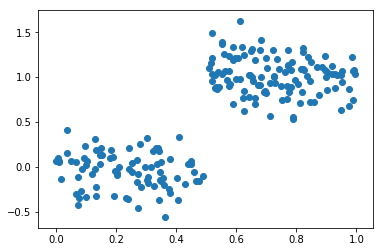

In [11]:
plt.scatter(datadf.iloc[:,0], datadf.iloc[:,1])
plt.show()

In [12]:
datadf1 = pd.read_csv("ex0.txt", sep='\t', header=None)
dataMat1 = np.mat(datadf1.iloc[:,1:3])
createTree(dataMat1)

{'left': {'left': {'left': 3.9871632,
   'right': 2.9836209534883724,
   'spInd': 0,
   'spVal': 0.797583},
  'right': 1.9800350714285715,
  'spInd': 0,
  'spVal': 0.582002},
 'right': {'left': 1.0289583666666666,
  'right': -0.02383815555555556,
  'spInd': 0,
  'spVal': 0.19783399999999998},
 'spInd': 0,
 'spVal': 0.39435}

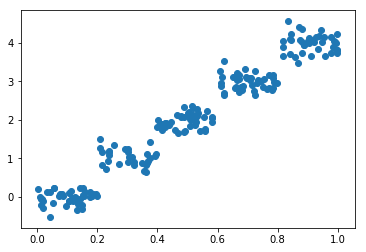

In [66]:
plt.scatter(datadf1.iloc[:,1], datadf1.iloc[:,2])
plt.show()

In [67]:
dataMat.shape

(200, 2)

## 9.1. 树剪枝
一棵树如果节点过多，表明该模型可能对数据进行了“过拟合”。可以通过在测试集上进行交叉验证来判断是否发生了过拟合。通过降低决策树的复杂程度来避免过拟合的过程称为“剪枝”。在函数chooseBestSplit()中的提前终止条件，实际上是在进行一种所谓的预剪枝(prepruning)操作。另一种形式的剪枝需要使用测试机和训练集，称为“后剪枝”。

### 9.1.1. 预剪枝
构建树的算法对输入的参数tolS和tolN非常敏感，例如使用下面的值构建出的树将十分臃肿。

In [14]:
createTree(dataMat, ops=(0,1))

{'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': 1.035533,
                'right': 1.077553,
                'spInd': 0,
                'spVal': 0.9933489999999999},
               'right': {'left': 0.744207,
                'right': 1.0690620000000002,
                'spInd': 0,
                'spVal': 0.9888520000000001},
               'spInd': 0,
               'spVal': 0.9898879999999999},
              'right': 1.227946,
              'spInd': 0,
              'spVal': 0.985425},
             'right': {'left': {'left': 0.8629110000000001,
               'right': 0.673579,
               'spInd': 0,
               'spVal': 0.9750219999999999},
              'right': {'left': {'left': 1.06469,
                'right': {'left': 0.945255,
                 'right': 1.0229059999999999,
                 'spInd': 0,
                 'spVal': 0.950153},
                'spInd': 0,
          

### 9.1.2. 后剪枝
后剪枝方法需要将数据集分为训练集和测试机。首先指定参数使得构建出的树足够大，足够复杂，便于剪枝。接下来从上而下找到叶节点，用测试机来判断将这些叶节点合并是否能降低测试误差，如果可以则合并。

函数prune()的伪代码如下：
```
基于已有的树切分测试数据：
    如果存在任一子集是一棵树，则在该子集递归剪枝过程
    计算将当前两个叶节点合并后的误差
    计算不合并的误差
    如果合并会降低误差的话，就将叶节点合并
```

In [28]:
# 上面将树存储在字典里
def isTree(obj):
    return (type(obj).__name__=='dict')

def getMean(tree):
    if isTree(tree['right']):
        tree['right'] = getMean(tree['right'])
    if isTree(tree['left']):
        tree['left'] = getMean(tree['left'])
        
    return (tree['left']+tree['right'])/2.0

def prune(tree, testData):
    # 没有测试数据，对树进行塌陷处理
    if testData.shape[0] == 0:
        return getMean(tree)
    
    if (isTree(tree['right'])) or isTree(tree['left']):
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
    if isTree(tree['left']):
        tree['left'] = prune(tree['left'], lSet)
    if isTree(tree['right']):
        tree['right'] = prune(tree['right'], rSet)
    if not isTree(tree['left']) and not isTree(tree['right']):
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
        errorNoMerge = sum(np.power(lSet[:,-1]-tree['left'], 2)) + sum(np.power(rSet[:,-1]-tree['right'], 2))
        treeMean = (tree['left']+tree['right'])/2.0
        errorMerge = sum(np.power(testData[:,-1] - treeMean, 2))
        if errorMerge < errorNoMerge:
            print("mergeing")
            return treeMean
        else:
            return tree
    else:
        return tree

In [29]:
ex2df = pd.read_csv("ex2.txt", sep='\t', header=None)
ex2testdf = pd.read_csv("ex2test.txt", sep='\t', header=None)
ex2Mat = np.mat(ex2df)
ex2testMat = np.mat(ex2testdf)

myTree = createTree(ex2Mat, ops=(0,1))
prune(myTree, ex2testMat)
myTree

mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing
mergeing


{'left': {'left': {'left': {'left': 92.5239915,
    'right': {'left': {'left': {'left': 112.38676399999999,
       'right': 123.559747,
       'spInd': 0,
       'spVal': 0.960398},
      'right': 135.83701299999998,
      'spInd': 0,
      'spVal': 0.958512},
     'right': 111.2013225,
     'spInd': 0,
     'spVal': 0.956951},
    'spInd': 0,
    'spVal': 0.9659690000000001},
   'right': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': 96.41885225,
              'right': 69.318649,
              'spInd': 0,
              'spVal': 0.9488219999999999},
             'right': {'left': {'left': 110.0350385,
               'right': {'left': 65.548418,
                'right': {'left': 115.75399399999999,
                 'right': {'left': {'left': 94.3961145,
                   'right': 85.005351,
                   'spInd': 0,
                   'spVal': 0.9121610000000001},
                  'right': {'left': {'left': 106.81466699999999,
 

## 9.2. 模型树
除了把叶节点简单地设定为常数值之外，还可以把叶节点设为分段线性函数，分段线性(piecewise liner)是指模型由多个线性片段组成，类似于分段函数。

In [32]:
def linerSove(dataSet):
    m,n = dataSet.shape
    X = np.mat(np.ones((m,n)))
    Y = np.mat(np.ones((m,1)))
    X[:,1:n] = dataSet[:,0:n-1]
    Y = dataSet[:,-1]
    xTx = X.T*X
    if np.linalg.det(xTx) == 0.0:
        raise NameError('This matris is singular, cannot do inverse,try increasing the second value of ops')
    ws = xTx.I * (X.T * Y)
    return ws, X , Y

def modelLeaf(dataSet):
    ws,X,Y = linerSove(dataSet)
    return ws

def modelErr(dataSet):
    ws, X, Y = linerSove(dataSet)
    yHat = X * ws
    return sum(np.power(Y-yHat, 2))

In [35]:
modeldf = pd.read_csv('exp2.txt',sep='\t',header=None)
modelMat = np.mat(modeldf)
createTree(modelMat, modelLeaf, modelErr, (1,10))

{'left': matrix([[1.69855694e-03],
         [1.19647739e+01]]), 'right': matrix([[3.46877936],
         [1.18521743]]), 'spInd': 0, 'spVal': 0.285477}

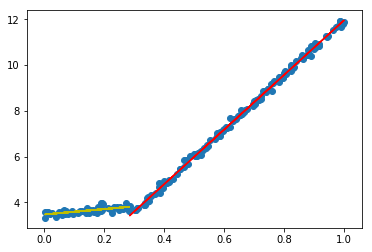

In [43]:
x = modeldf.iloc[:,0]
y = modeldf.iloc[:,1]

plt.scatter(x,y)

xl = x[x>=0.285477]
xr = x[x<0.285477]
yl = 0.0016985 + 11.96477*xl
yr = 3.46877963 + 1.18521743*xr
plt.plot(xl, yl, c='r')
plt.plot(xr, yr, c='y')
plt.show()

## 9.3. 树回归与标准回归的比较

In [44]:
# 回归树预测函数
def regTreeEval(model, inDat):
    return float(model)

# 模型树预测函数
def modelTreeEval(model, inDat):
    n = inDat.shape[1]
    X = np.mat(np.ones((1,n+1)))
    X[:,1:n+1] = inDat
    return float(X*model)

def treeForeCase(tree, inDat, modelEval = regTreeEval):
    if not isTree(tree): 
        return modelEval(tree, inDat)
    if inDat[tree['spInd']] > tree['spVal']:
        if isTree(tree['left']):
            return treeForeCase(tree['left'], inDat, modelEval)
        else:
            return modelEval(tree['left'], inDat)
    else:
        if isTree(tree['right']):
            return treeForeCase(tree['right'], inDat, modelEval)
        else:
            return modelEval(tree['right'], inDat)
        
def createForeCast(tree, testData, modelEval=regTreeEval):
    m = len(testData)
    yHat = np.mat(np.zeros((m,1)))
    for i in range(m):
        yHat[i] = treeForeCase(tree, np.mat(testData[i]), modelEval)
    return yHat

In [48]:
bikedf = pd.read_csv('bikeSpeedVsIq_train.txt', sep='\t', header = None)
biketestdf = pd.read_csv('bikeSpeedVsIq_test.txt', sep='\t', header = None)
bikeMat = np.mat(bikedf)
bikeTestMat = np.mat(biketestdf)

In [49]:
# 使用回归树进行预测

bikeTree = createTree(bikeMat, ops=(1,20))
yHat = createForeCast(bikeTree, bikeTestMat[:,0])
np.corrcoef(yHat, bikeTestMat[:,1], rowvar=0)[0,1]

0.964085231822214

In [51]:
# 使用模型树进行预测

bikeTree = createTree(bikeMat, modelLeaf, modelErr, ops=(1,20))
yHat = createForeCast(bikeTree,  bikeTestMat[:,0], modelTreeEval)
np.corrcoef(yHat, bikeTestMat[:,1], rowvar=0)[0,1]

0.9760412191380611

In [56]:
# 使用标准回归预测

ws, X, Y = linerSove(bikeMat)
yHat = np.mat(np.zeros((len(bikeTestMat), 1)))
for i in range(bikeTestMat.shape[0]):
    yHat[i] = bikeTestMat[i,0] * ws[1,0]+ws[0,0]
    
np.corrcoef(yHat, bikeTestMat[:,1], rowvar=0)[0,1]

0.9434684235674763

In [59]:
ws[1]

matrix([[6.18978355]])

In [55]:
ws

matrix([[37.58916794],
        [ 6.18978355]])